# Confounder analysis for the multi-center RPN-signature
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/5_confounder_analysis.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [8]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from mlxtend.evaluate import permutation_test
from mlconfound.stats import partial_confound_test
from mlconfound.plot import plot_graph

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

## Load and merge behavioral data for all three centers (after exclusions)

In [4]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()

### correct for different questionnaire evaluation in the Essen-sample
df.loc[df.study=='essen', 'psq'] *= 20 
df.loc[df.study=='essen', 'anx_state'] *= 20 
df.loc[df.study=='essen', 'anx_trait'] *= 20 

### negate the log mean mechanical detection threshold in center 3 (is already negated in center 2 and is not available in center 1)
df.loc[df.study=='szeged', 'MDT_log_geom'] *= -1 

df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,1.145363,78.0,89.0,7.0,37.0


## Load predictions newly proposed multi-center model

In [5]:
multicener_predictions = np.genfromtxt('../res/multi-center/nested_cv_pred_full_GroupKFold30.csv', delimiter=',')


## Test association with the confounder variables

In [6]:
for varname in ['meanFD', 'maxFD', 'perc_scrubbed', 'BP_QST_sys', 'BP_QST_dias', 'BP_MRI_sys', 'BP_MRI_dias', 'MRI_QST_dif',
               'Age', 'Male', 'BMI', 'day_menses', 'alk_per_w', 'edu', 
               'pcs_catastrophizing', 'pcs_rumination', 'psq', 'BDI', 'ads_k', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', #psq: pain sensitivity; PSQ20. precieved stress
               'CDT_log_mean', 'WDT_log_mean','MDT_log_geom', 't50', 'GABA_mean', 'Glx_mean' ]:

    isnan = np.isnan(df[varname])
    confunder=df[varname][~isnan]
    
    p_corr_s1 = permutation_test(multicener_predictions[~isnan][df.study[~isnan]=='bochum'], confunder[df.study[~isnan]=='bochum'],
                               func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                               method='approximate',
                               num_rounds=8000,
                               seed=42)

    
    corr_s1 = np.corrcoef(multicener_predictions[~isnan][df.study[~isnan]=='bochum'], confunder[df.study[~isnan]=='bochum'])[0,1]
    print(varname, '@center1     ', 'r =', np.round(corr_s1, 2), ' p =', np.round(p_corr_s1, 3))

    p_corr_s2 = permutation_test(multicener_predictions[~isnan][df.study[~isnan]=='essen'], confunder[df.study[~isnan]=='essen'],
                                   func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                                   method='approximate',
                                   num_rounds=8000,
                                   seed=42)
    corr_s2 = np.corrcoef(multicener_predictions[~isnan][df.study[~isnan]=='essen'], confunder[df.study[~isnan]=='essen'])[0,1]
    print(varname, '@center2     ', 'r =', np.round(corr_s2, 2), ' p =', np.round(p_corr_s2, 3))

    p_corr_s3 = permutation_test(multicener_predictions[~isnan][df.study[~isnan]=='szeged'], confunder[df.study[~isnan]=='szeged'],
                                   func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                                   method='approximate',
                                   num_rounds=8000,
                                   seed=42)
    corr_s3 = np.corrcoef(multicener_predictions[~isnan][df.study[~isnan]=='szeged'], confunder[df.study[~isnan]=='szeged'])[0,1]
    print(varname, '@center3     ', 'r =', np.round(corr_s3, 2), ' p =', np.round(p_corr_s3, 3))

    p_corr_s123 = permutation_test(multicener_predictions[~isnan], confunder,
                                   func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                                   method='approximate',
                                   num_rounds=8000,
                                   seed=42)
    corr_s123 = np.corrcoef(multicener_predictions[~isnan], confunder)[0,1]
    
    pct = partial_confound_test(y=df.mean_QST_pain_sensitivity[~isnan],
                                yhat=multicener_predictions[~isnan],
                                c=confunder)
    
    print(varname, '@center1-2-3 ', 'r =', np.round(corr_s123, 2), ' p =', np.round(p_corr_s123, 3))
    print(varname, 'PCT', 'p =', pct.p)
    print('--------------------------------------------------')


meanFD @center1      r = -0.08  p = 0.626
meanFD @center2      r = 0.03  p = 0.852
meanFD @center3      r = -0.04  p = 0.86


Permuting: 100%|██████████| 1000/1000 [00:03<00:00, 275.00it/s]


meanFD @center1-2-3  r = -0.04  p = 0.688
meanFD PCT p = 0.762
--------------------------------------------------
maxFD @center1      r = -0.02  p = 0.896
maxFD @center2      r = 0.2  p = 0.219
maxFD @center3      r = 0.12  p = 0.629


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 784.30it/s]


maxFD @center1-2-3  r = 0.01  p = 0.924
maxFD PCT p = 0.948
--------------------------------------------------
perc_scrubbed @center1      r = -0.05  p = 0.805
perc_scrubbed @center2      r = -0.09  p = 0.59
perc_scrubbed @center3      r = -0.07  p = 0.806


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 747.58it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


perc_scrubbed @center1-2-3  r = -0.1  p = 0.357
perc_scrubbed PCT p = 0.474
--------------------------------------------------
BP_QST_sys @center1      r = nan  p = 0.0
BP_QST_sys @center2      r = -0.15  p = 0.354
BP_QST_sys @center3      r = -0.06  p = 0.798


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 817.29it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


BP_QST_sys @center1-2-3  r = -0.15  p = 0.31
BP_QST_sys PCT p = 0.33
--------------------------------------------------
BP_QST_dias @center1      r = nan  p = 0.0
BP_QST_dias @center2      r = -0.25  p = 0.139
BP_QST_dias @center3      r = -0.46  p = 0.1


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 771.47it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


BP_QST_dias @center1-2-3  r = -0.22  p = 0.122
BP_QST_dias PCT p = 0.158
--------------------------------------------------
BP_MRI_sys @center1      r = nan  p = 0.0
BP_MRI_sys @center2      r = 0.0  p = 0.988
BP_MRI_sys @center3      r = 0.08  p = 0.756


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 593.04it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


BP_MRI_sys @center1-2-3  r = -0.08  p = 0.581
BP_MRI_sys PCT p = 0.592
--------------------------------------------------
BP_MRI_dias @center1      r = nan  p = 0.0
BP_MRI_dias @center2      r = 0.3  p = 0.082
BP_MRI_dias @center3      r = -0.1  p = 0.691


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 670.06it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


BP_MRI_dias @center1-2-3  r = 0.1  p = 0.481
BP_MRI_dias PCT p = 0.463
--------------------------------------------------
MRI_QST_dif @center1      r = nan  p = 0.0
MRI_QST_dif @center2      r = 0.01  p = 0.967
MRI_QST_dif @center3      r = 0.19  p = 0.45


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 766.83it/s]


MRI_QST_dif @center1-2-3  r = 0.14  p = 0.143
MRI_QST_dif PCT p = 0.162
--------------------------------------------------
Age @center1      r = -0.03  p = 0.862
Age @center2      r = -0.13  p = 0.429
Age @center3      r = 0.31  p = 0.188


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 738.40it/s]


Age @center1-2-3  r = -0.05  p = 0.611
Age PCT p = 0.67
--------------------------------------------------
Male @center1      r = -0.05  p = 0.772
Male @center2      r = 0.24  p = 0.156
Male @center3      r = 0.32  p = 0.183


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 650.98it/s]


Male @center1-2-3  r = 0.11  p = 0.322
Male PCT p = 0.402
--------------------------------------------------
BMI @center1      r = -0.15  p = 0.383
BMI @center2      r = -0.02  p = 0.925
BMI @center3      r = 0.25  p = 0.3


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 689.58it/s]


BMI @center1-2-3  r = 0.02  p = 0.887
BMI PCT p = 0.931
--------------------------------------------------
day_menses @center1      r = 0.34  p = 0.33
day_menses @center2      r = -0.22  p = 0.376
day_menses @center3      r = -0.15  p = 0.715


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 781.87it/s]


day_menses @center1-2-3  r = -0.17  p = 0.302
day_menses PCT p = 0.532
--------------------------------------------------
alk_per_w @center1      r = 0.06  p = 0.753
alk_per_w @center2      r = 0.14  p = 0.392


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


alk_per_w @center3      r = nan  p = 0.0


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 663.88it/s]


alk_per_w @center1-2-3  r = -0.07  p = 0.561
alk_per_w PCT p = 0.635
--------------------------------------------------
edu @center1      r = 0.05  p = 0.753
edu @center2      r = -0.08  p = 0.643


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


edu @center3      r = nan  p = 0.0


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 727.15it/s]


edu @center1-2-3  r = -0.04  p = 0.705
edu PCT p = 0.767
--------------------------------------------------
pcs_catastrophizing @center1      r = -0.03  p = 0.886
pcs_catastrophizing @center2      r = -0.22  p = 0.19
pcs_catastrophizing @center3      r = -0.03  p = 0.898


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 705.31it/s]


pcs_catastrophizing @center1-2-3  r = -0.06  p = 0.598
pcs_catastrophizing PCT p = 0.702
--------------------------------------------------
pcs_rumination @center1      r = -0.07  p = 0.694


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


pcs_rumination @center2      r = nan  p = 0.0
pcs_rumination @center3      r = nan  p = 0.0


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 828.17it/s]


pcs_rumination @center1-2-3  r = -0.07  p = 0.694
pcs_rumination PCT p = 0.781
--------------------------------------------------
psq @center1      r = -0.01  p = 0.965
psq @center2      r = -0.01  p = 0.969
psq @center3      r = 0.04  p = 0.884


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 712.28it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


psq @center1-2-3  r = 0.1  p = 0.354
psq PCT p = 0.455
--------------------------------------------------
BDI @center1      r = nan  p = 0.0
BDI @center2      r = nan  p = 0.0
BDI @center3      r = -0.08  p = 0.749


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 806.02it/s]


BDI @center1-2-3  r = -0.08  p = 0.749
BDI PCT p = 0.801
--------------------------------------------------
ads_k @center1      r = -0.06  p = 0.731
ads_k @center2      r = 0.02  p = 0.913
ads_k @center3      r = -0.11  p = 0.733


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 742.17it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ads_k @center1-2-3  r = 0.05  p = 0.642
ads_k PCT p = 0.665
--------------------------------------------------
PSQI @center1      r = nan  p = 0.0
PSQI @center2      r = 0.1  p = 0.562
PSQI @center3      r = 0.31  p = 0.256


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 747.71it/s]


PSQI @center1-2-3  r = 0.27  p = 0.058
PSQI PCT p = 0.277
--------------------------------------------------
anx_state @center1      r = 0.19  p = 0.264
anx_state @center2      r = 0.01  p = 0.945
anx_state @center3      r = -0.04  p = 0.858


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 776.20it/s]


anx_state @center1-2-3  r = -0.04  p = 0.69
anx_state PCT p = 0.693
--------------------------------------------------
anx_trait @center1      r = 0.17  p = 0.32
anx_trait @center2      r = 0.04  p = 0.815
anx_trait @center3      r = 0.02  p = 0.924


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 757.07it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


anx_trait @center1-2-3  r = 0.03  p = 0.782
anx_trait PCT p = 0.832
--------------------------------------------------
PSQ20 @center1      r = nan  p = 0.0
PSQ20 @center2      r = -0.0  p = 0.976
PSQ20 @center3      r = -0.01  p = 0.977


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 782.74it/s]


PSQ20 @center1-2-3  r = 0.2  p = 0.141
PSQ20 PCT p = 0.527
--------------------------------------------------
CDT_log_mean @center1      r = 0.09  p = 0.593
CDT_log_mean @center2      r = -0.0  p = 0.984
CDT_log_mean @center3      r = -0.18  p = 0.417


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 732.18it/s]


CDT_log_mean @center1-2-3  r = 0.15  p = 0.162
CDT_log_mean PCT p = 0.17
--------------------------------------------------
WDT_log_mean @center1      r = -0.17  p = 0.318
WDT_log_mean @center2      r = 0.05  p = 0.744
WDT_log_mean @center3      r = 0.26  p = 0.29


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 780.56it/s]
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


WDT_log_mean @center1-2-3  r = 0.13  p = 0.225
WDT_log_mean PCT p = 0.24
--------------------------------------------------
MDT_log_geom @center1      r = nan  p = 0.0
MDT_log_geom @center2      r = -0.07  p = 0.672
MDT_log_geom @center3      r = 0.15  p = 0.554


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 729.38it/s]


MDT_log_geom @center1-2-3  r = -0.27  p = 0.051
MDT_log_geom PCT p = 0.134
--------------------------------------------------
t50 @center1      r = -0.33  p = 0.042


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


t50 @center2      r = nan  p = 0.0
t50 @center3      r = nan  p = 0.0


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 724.87it/s]


t50 @center1-2-3  r = -0.33  p = 0.042
t50 PCT p = 0.523
--------------------------------------------------
GABA_mean @center1      r = 0.31  p = 0.069


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


GABA_mean @center2      r = nan  p = 0.0
GABA_mean @center3      r = nan  p = 0.0


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 731.97it/s]


GABA_mean @center1-2-3  r = 0.31  p = 0.069
GABA_mean PCT p = 0.13
--------------------------------------------------
Glx_mean @center1      r = 0.33  p = 0.05


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Glx_mean @center2      r = nan  p = 0.0
Glx_mean @center3      r = nan  p = 0.0


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 761.52it/s]

Glx_mean @center1-2-3  r = 0.33  p = 0.05
Glx_mean PCT p = 0.207
--------------------------------------------------


## Plot significant associations

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 640.95it/s]


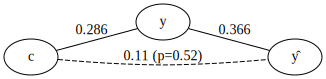

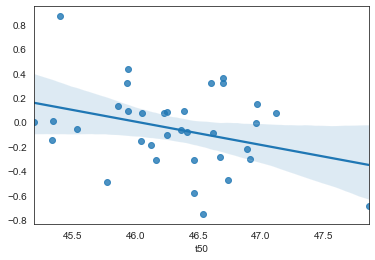

In [13]:
sns.regplot(df.t50, multicener_predictions)
plot_graph(partial_confound_test(y=df.mean_QST_pain_sensitivity[~ np.isnan(df.t50)],
                                yhat=multicener_predictions[~ np.isnan(df.t50)],
                                c=df.t50[~ np.isnan(df.t50)]))

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 775.67it/s]


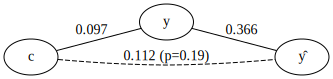

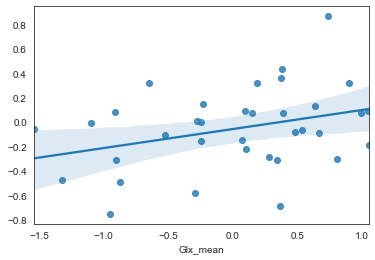

In [14]:
sns.regplot(df.Glx_mean, multicener_predictions)
plot_graph(partial_confound_test(y=df.mean_QST_pain_sensitivity[~ np.isnan(df.Glx_mean)],
                                yhat=multicener_predictions[~ np.isnan(df.Glx_mean)],
                                c=df.Glx_mean[~ np.isnan(df.Glx_mean)]))